<a href="https://colab.research.google.com/github/gyeongee/TIL/blob/main/VGG16_0814.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. 모듈 가져오기
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else 'cpu'
from pytz import timezone

In [ ]:
# 2.Hyperparameters
Random_seed = 42 #그냥 정하는 것
Learning_rate = 0.0001 # 학습률. 논문에서는 0.01로 시작하여 감소시키지만 우선 0.0001로 해보자
Batch_size = 64 # batch size. 이 단위로 학습이 된다.
N_epochs = 50 # epoch 횟수 전체 데이터가 50번 학습된다는 뜻.
Img_size = 224 # 224*224 RGB 이미지가 들어갈 것이다.
N_classes = 10 # 데이터셋의 10개의 output class가 있다.

In [ ]:
# 3.get_accuaracy 함수
def get_accuracy(model,data_loader,device):
  correct_pred=0
  n = 0
  with torch.no_grad():
    model.eval()
    for X,y_true in data_loader:
      # 데이터 gpu에 올리기
      X = X.to(device)
      y_true = y_true.to(device)
      _,y_prob = model(X) # y_prob은 후에 나올 LeNet-5 모델에서 소프트맥스 함수를 통과한 클래스 확률
      _,predicted_labels = torch.max(y_prob,1)

      n+=y_true.size(0)
      correct_pred += (predicted_labels == y_true).sum()
  return correct_pred.float() # 정확히 맞춘 것 / 총 개수

In [ ]:
# 4. 손실 plotting 함수
def plot_loss(train_loss, val_loss):
  plt.style.use('grayscale')
  train_loss=np.array(train_loss)
  val_loss = np.array(val_loss)
  fig.ax = plt.subplots(1,1,figsize=(8,4,5))
  ax.plot(train_loss, color='green',label='Training Loss')
  ax.plot(val_loss, color='purple', label='Validation Loss')
  ax.set(title = 'Loss Over Epochs', xlabel ='EPOCH', ylabel='LOSS')
  ax.legend()
  fig.show()
  plt.style.use('default')


In [ ]:
# Train함수
def train(train_loader, model,criterion, optimizer,device):
  model.train() # 모델을 학습 모드로 설정
  running_loss = 0 # 초기값을 0으로 설정
  for X,y_true in train_loader:
    optimizer.zero_grad() # 오차역전파
    X=X.to(device)
    y_true = y_true.to(device)
    y_hat,_ = model(X)
    loss = criterion(y_hat, y_true) # loss를 구함
    running_loss += loss.item() * X.size(0) # 사이즈를 곱해줘서 전체적인 running loss 를 구함
    loss.backward() # 역전파
    optimizer.step() # 기울기 손실
  epoch_loss = running_loss/len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [ ]:
# 6. validate 함수
def validate(val_loader,model,criterion, device):
  model.eval()
  running_loss=0

  for X,y_true in val_loader:
      X = X.to(device)
      y_true = y_true.to(device)

      # 순전파와 손실 기록하기
      y_hat,_ = model(X)
      loss = criterion(y_hat, y_true)
      running_loss += loss.item()*X.size(0)
  epoch_loss = running_loss / len(val_loader.dataset)
  return model, epoch_loss


In [ ]:
# 7. Training_loop함수
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):

    # metrics를 저장하기 위한 객체 설정
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # model 학습하기
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            val_acc = get_accuracy(model, val_loader, device=device)

            print(datetime.now(timezone('Asia/Seoul')).time().replace(microsecond=0),'--- ',
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * val_acc:.2f}')

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)



In [ ]:
# 모델
class VGG16(nn.Module):

    def __init__(self, n_classes):
        super(VGG16, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1,padding=1), #Bias default
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # default stride = kernel_size
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features = 25088, out_features = 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=n_classes)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1) # 1차원으로 쫙펴준다
        logits = self.classifier(x) # classifier에 통과시켜준다
        probs = F.softmax(logits, dim=1) # 나온 10개의 값들을 softmax로 확률 구해준다.
        return logits, probs

데이터불러오기

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Vision공부"

/content/drive/MyDrive/Colab Notebooks/Vision공부


In [ ]:
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
from pytz import timezone
import os

In [ ]:
Random_seed = 42 #그냥 정하는 것
Learning_rate = 0.0001 # 학습률. 논문에서는 0.01로 시작하여 감소시키지만 우선 0.0001로 해보자
Batch_size = 64 # batch size. 이 단위로 학습이 된다.
N_epochs = 50 # epoch 횟수 전체 데이터가 50번 학습된다는 뜻.
Img_size = 224 # 224*224 RGB 이미지가 들어갈 것이다.
N_classes = 10 # 데이터셋의 10개의 output class가 있다.

In [ ]:
# 사전에 정의된 이미지 데이터 불러오기
from torchvision import datasets,transforms

In [ ]:
# CIFAR-10 dataset 불러오기
train_ds = datasets.STL10(root='./data',split='train',download=True,transform=transforms.ToTensor())
val_ds = datasets.STL10(root='./data',split='test',download=True, transform=transforms.ToTensor())


5000
8000


torch.Size([3, 96, 96])

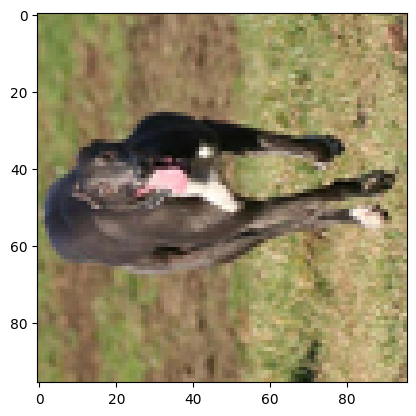

In [ ]:
plt.imshow(train_ds.data[1].T,cmap='gray_r')
print(len(train_ds)) # train data의 개수
print(len(val_ds)) # validate data의 개수
train_ds[0][0].shape

### 이미지 전처리
- 이미지 정규화 진행

In [ ]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

# 0.4467106 0.43980986 0.40664646
# 0.44723064 0.4396425 0.40495726

0.4467106 0.43980986 0.40664646
0.44723064 0.4396425 0.40495726


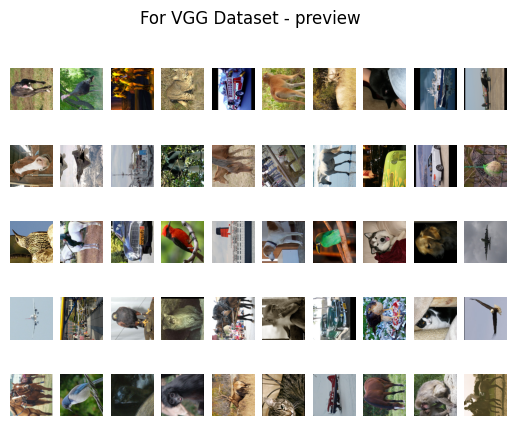

In [ ]:
# transforms 정의하기
transforms_set = transforms.Compose([transforms.Resize((256,256)),transforms.RandomCrop((224,224)),transforms.ToTensor()
                                     ,transforms.Normalize([train_meanR,train_meanG,train_meanB],[train_stdR,train_stdG,train_stdB])])

# 불러온 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_ds.data[index].T, cmap='gray_r')
fig.suptitle('For VGG Dataset - preview');

In [ ]:
# 정의한 transforms를 train, validate 데이터셋에 적용하고 변환된 이미지 사이즈를 확인
train_ds.transform=transforms_set
val_ds.transform = transforms_set
train_ds[0][0].size()

torch.Size([3, 224, 224])

In [ ]:
# DataLoader만 정의
train_loader = DataLoader(dataset=train_ds,
                          batch_size=Batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_ds,
                        batch_size=Batch_size,
                        shuffle=False)

In [ ]:
torch.manual_seed(Random_seed)

model = VGG16(N_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=0)
criterion = nn.CrossEntropyLoss()

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader,
                                    val_loader, N_epochs, DEVICE)

19:04:58 ---  Epoch: 0	Train loss: 2.3026	Valid loss: 2.3026	Train accuracy: 50000.00	Valid accuracy: 80000.00


KeyboardInterrupt: 